# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 481913558383002826, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 1218052096
 locality {
   bus_id: 1
 }
 incarnation: 3642381549086338819
 physical_device_desc: "device: 0, name: GeForce GTX 760, pci bus id: 0000:01:00.0"]

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
# All imports
import pickle
from random import shuffle
import numpy as np
from itertools import groupby
import cv2
import os
from IPython import display
import time
import pylab as pl
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import csv

%matplotlib inline

In [3]:
# Load test set, create validation set if needed

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

def maybe_create_validation_set(validation_amount, donor_filename):
    if os.path.isfile(validation_file):
        return
    
    print("Creating validation set")
    
    donor_set = pickle.load(open(donor_filename, "rb"))
    zipped = zip(donor_set['features'], donor_set['labels'])
    
    dictionary = {}
    
    for feature, label in zipped:
        dictionary.setdefault(label, []).append(feature)
        
    valid_zipped = []
    donor_zipped = []
    
    for label, features in dictionary.items():
        np.random.shuffle(features)
        split_point = int(len(features) * validation_amount)
        
        for feature in features[:split_point]:
            valid_zipped.append((label, feature))
        
        for feature in features[split_point:]:
            donor_zipped.append((label, feature))

    np.random.shuffle(valid_zipped)
    np.random.shuffle(donor_zipped)

    valid_labels, valid_features = zip(*valid_zipped)
    donor_labels, donor_features = zip(*donor_zipped)
    
    pickle.dump({'features': np.array(donor_features), 'labels': np.array(donor_labels)},
                open(donor_filename, "wb"))
    
    pickle.dump({'features': np.array(valid_features), 'labels': np.array(valid_labels)}, 
                open(validation_file, "wb"))
        
            
maybe_create_validation_set(0.6, testing_file)


train = pickle.load(open(training_file, "rb"))
valid = pickle.load(open(validation_file, "rb"))
test = pickle.load(open(testing_file, "rb"))   
    
X_train = train['features']
y_train = train['labels']

X_valid = valid['features']
y_valid = valid['labels']

X_test = test['features']
y_test = test['labels']

In [4]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

image_shape = np.array(X_test.shape[1:])

n_classes = len(list(groupby(sorted(y_train))))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 33337
Number of validation examples = 7578
Number of testing examples = 5052
Image data shape = [32 32  3]
Number of classes = 43


In [5]:
# Preprocessing

def to_onehot(label):
    result = np.zeros(n_classes, dtype=np.bool)
    result[label] = 1
    return result
    
def convert_dataset(convert_fun, dataset):
    return list(map(convert_fun, dataset))

def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    shape = img.shape
    return cv2.equalizeHist(gray).reshape(shape[0], shape[1], 1)

def to_hv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    v = hsv[:,:,2]
    
    v = cv2.equalizeHist(v)
    
    return np.stack((h, v), axis = 2)

X_train_grayscale = convert_dataset(to_grayscale, X_train)
X_valid_grayscale = convert_dataset(to_grayscale, X_valid)
X_test_grayscale = convert_dataset(to_grayscale, X_test)

X_train_hv = convert_dataset(to_hv, X_train)
X_valid_hv = convert_dataset(to_hv, X_valid)
X_test_hv = convert_dataset(to_hv, X_test)

y_train_onehot = convert_dataset(to_onehot, y_train)
y_valid_onehot = convert_dataset(to_onehot, y_valid)
y_test_onehot = convert_dataset(to_onehot, y_test)

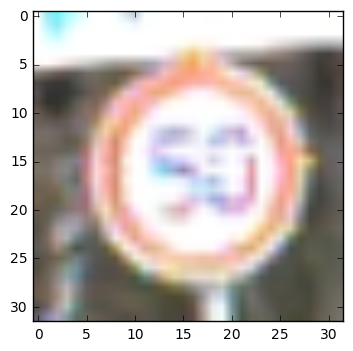

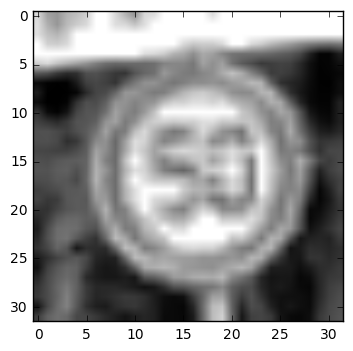

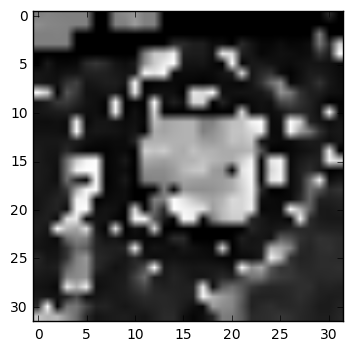

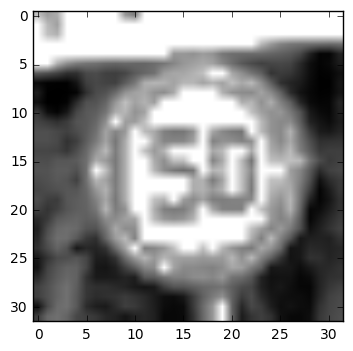

In [6]:
def show_img(img):
    shape = img.shape
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    elif img.ndim == 3:
        if shape[2] == 1:
            plt.imshow(img.reshape(shape[0], shape[1]), cmap='gray')
        elif shape[2] == 2:
            show_img(img[:,:,0])
            show_img(img[:,:,1])
        else:
            plt.imshow(img)
    plt.show()

img_index = 0
show_img(X_train[img_index])
show_img(X_train_grayscale[img_index])
show_img(X_train_hv[img_index])

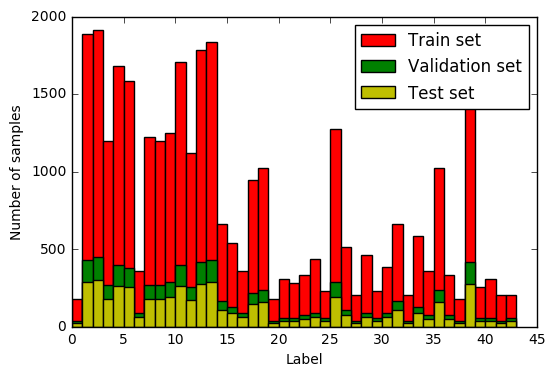

In [7]:
def build_labels_counts(labels):
    return list(zip(*map(lambda x: (x[0], len(list(x[1]))), groupby(sorted(labels)))))

trainset_counts = build_labels_counts(y_train)
validset_count = build_labels_counts(y_valid)
testset_count = build_labels_counts(y_test)

width = 1

train_plot = plt.bar(trainset_counts[0], trainset_counts[1], width, label="Train set", color='r')
valid_plot = plt.bar(validset_count[0], validset_count[1], width, label="Validation set", color='g')
test_plot = plt.bar(testset_count[0], testset_count[1], width, label="Test set", color='y')


plt.legend(handles=[train_plot, valid_plot, test_plot])

plt.ylabel("Number of samples")
plt.xlabel("Label")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
# Helper functions

class Net:
    def __init__(self, tf_node, x_placeholder):
        self.tf_node = tf_node
        self.x_placeholder = x_placeholder

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def create_biases(shape):
    return tf.Variable(tf.constant(0.1, shape = shape))

def conv2d(input_layer, filter_size, out_channels, stride=1, padding='SAME'):
    input_shape = input_layer.get_shape().as_list()
    
    #weights_shape = [*input_shape[1:], out_channels]
    weights_shape = [filter_size, filter_size, input_shape[3], out_channels]
       
    weights = create_weights(weights_shape)
    biases = create_biases([out_channels])
    
    output_layer = tf.nn.conv2d(input_layer, weights, [1, stride, stride, 1], padding)
    output_layer = tf.nn.bias_add(output_layer, biases)
    
    return (output_layer, weights)

def max_pool(input_layer, size=2, padding='SAME'):
    dimensions = [1, size, size, 1]
    return tf.nn.max_pool(input_layer, dimensions, dimensions, padding)

def densely_connected(input_layer, output_nodes_number):
    input_shape = input_layer.get_shape().as_list()
    flat_size = np.prod(input_shape[1:]) 
    
    flat_input = tf.reshape(input_layer, [-1, flat_size])
    
    weights = create_weights([flat_size, output_nodes_number])
    biases = create_biases([output_nodes_number])
    
    result = tf.matmul(flat_input, weights)
    result = tf.nn.bias_add(result, biases)
    
    return result 


def chunks(input_list, chunk_size):
    return np.array([input_list[i:i+chunk_size] for i in range(0, len(input_list), chunk_size)])

def chunks2(list1, list2, chunk_size):
    return zip(chunks(list1, chunk_size), chunks(list2, chunk_size))

def create_batches(features, labels, batch_size):
    zipped = list(zip(features, labels))
    shuffle(zipped)
    unzipped = list(zip(*zipped))
    
    new_features = chunks(unzipped[0], batch_size)
    new_labels = chunks(unzipped[1], batch_size)
    
    return list(zip(new_features, new_labels))

def evaluate_net(net, session, features, labels):
    equal_fun = tf.equal(tf.argmax(net.tf_node, 1), tf.argmax(y_placeholder, 1))
    correct_num_func = tf.reduce_sum(tf.cast(equal_fun, tf.float32))
    correct_num = 0
          
    for features_chunk, labels_chunk in chunks2(features, labels, 100):
        correct_num += session.run(correct_num_func, feed_dict={
                net.x_placeholder: features_chunk, 
                y_placeholder: labels_chunk, 
                dropout_placeholder: 1})
    
    return correct_num / len(features)

def train(net, optimizer, session, features, validation_features, learning_rate, iterations, batch_size, dropout, silent_mode):
    iteration = 0
    
    train_plot = []
    valid_plot = []

    while True:
        batches = create_batches(features, y_train_onehot, batch_size)
        for features_batch, labels_batch in batches:
            iteration = iteration + 1
            if iteration >= iterations:                
                return evaluate_net(net, session, validation_features, y_valid_onehot)
                       
            session.run(optimizer, feed_dict={
                    net.x_placeholder: features_batch, 
                    y_placeholder: labels_batch, 
                    dropout_placeholder: dropout, 
                    learning_rate_placeholder: learning_rate
                })
    
            if not silent_mode and (iteration % (iterations/PLOT_RESOLUTION) == 0 or iteration == iterations-1):
                valid_accuracy = evaluate_net(net, session, validation_features, y_valid_onehot)
                train_accuracy = evaluate_net(net, session, features, y_train_onehot)
                
                train_plot.append(train_accuracy)
                valid_plot.append(valid_accuracy)
                
                plt.clf()
                plt.ylim(0,1)
                r, = plt.plot(valid_plot, 'r', label = "Validation set accuracy")
                g, = plt.plot(train_plot, 'g', label = "Train set accuracy")
                plt.legend(handles=[r,g])
                display.clear_output(wait=True)
                display.display(pl.gcf())
                                
                print("Iteration:", iteration)
                print("  valid accuracy:", valid_accuracy)
                print("  Train accuracy:", train_accuracy)  

class GridNode:
    def __init__(self, net, name, features, validation_features, test_features, learning_rate, dropout):
        self.net = net
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.features = features
        self.validation_features = validation_features
        self.test_features = test_features
        self.net_name = name
                
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net.tf_node, y_placeholder))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate_placeholder).minimize(cross_entropy)
        
    def describe(self):
        return "{0}, Learning rate: {1}, dropout: {2}".format(name, learning_rate, dropout)

In [ ]:
ITERATIONS = 40000
BATCH_SIZE = 50
PLOT_RESOLUTION = 10


dropout_placeholder = tf.placeholder(tf.float32)
learning_rate_placeholder = tf.placeholder(tf.float32)
y_placeholder = tf.placeholder("float", [None, n_classes])

def simple_ss_net(input_shape, out_channels1, out_channels2, hidden_layers):   
    x_placeholder = tf.placeholder("float", input_shape)
    
    layer1, w = conv2d(x_placeholder, 5, out_channels1)
    layer1 = max_pool(layer1)
    
    layer2, w = conv2d(layer1, 5, out_channels2)
    layer2 = max_pool(layer2)
    
    last_layer = layer2
    for hidden_layer in hidden_layers:
        last_layer = densely_connected(last_layer, hidden_layer)
    
    last_layer = tf.nn.dropout(last_layer, dropout_placeholder)
    
    result = densely_connected(last_layer, n_classes)
    
    return Net(result, x_placeholder)

grid = []

learning_rates = [1e-4, 1e-5]
dropouts = [0.3, 0.35, 0.4, 0.5]

def add_to_grid(features, validation_features, test_features, net_name, create_net_func):
    for learning_rate in learning_rates:
        for dropout in dropouts:
            net = create_net_func()
            
            node = GridNode(net, net_name, features, validation_features, test_features, learning_rate, dropout)
            grid.append(node)

add_to_grid(X_train, X_valid, X_test, "SS RGB 100x100",
            lambda: simple_ss_net([None, *image_shape], 100, 100, []))

add_to_grid(X_train_grayscale, X_valid_grayscale, X_test_grayscale, "SS GRAY 100x100",
            lambda: simple_ss_net([None, 32, 32, 1], 100, 100, []))

add_to_grid(X_train_hv, X_valid_hv, X_test_hv, "SS HV 100x100",
            lambda: simple_ss_net([None, 32, 32, 2], 100, 100, []))

try:
    session.close()
except:
    pass

session = tf.Session()
session.run(tf.global_variables_initializer())

best_node = None
best_node_accuracy = 0

start_time = time.time()

node_index = 1
for node in grid:
    name = node.net_name
    optimizer = node.optimizer
    net = node.net
    features = node.features
    validation_features = node.validation_features
    learning_rate = node.learning_rate
    dropout = node.dropout
    
    print("Node: {0}/{1}, {2}".format(node_index, len(grid), node.describe()))
    node_index = node_index + 1
    
    validation_result = train(net, 
                              optimizer, 
                              session, 
                              features, 
                              validation_features, 
                              learning_rate, 
                              ITERATIONS, 
                              BATCH_SIZE, 
                              dropout, 
                              True)
    print("Validation accuracy:",validation_result)
    print("Time elapsed:", int(time.time() - start_time))
    print()
    
    if validation_result > best_node_accuracy:
        best_node_accuracy = validation_result
        best_node = node

        

print("Training finished")
print("Total time elapsed:", int(time.time() - start_time))
print("Best validation accuracy: {0:.2f}; name: {1}".format(best_node_accuracy, best_node.describe()))
print("Test accuracy: ", evaluate_net(best_node.net, session, best_node.test_features, y_test_onehot))

Node: 1/24, SS RGB 100x100, Learning rate: 0.0001, dropout: 0.3


In [10]:
def get_signs_names():
    result = {}
    with open('signnames.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            classId = int(row['ClassId'])
            name = row['SignName']
            result[classId] = name
    return result
                    
sign_names = get_signs_names()

def show_what_net_thinks(sample):
    net = best_node.net
    probs = session.run(tf.nn.softmax(net.tf_node), feed_dict={net.x_placeholder: [sample], dropout_placeholder: 1})[0]

    for i in range(len(probs)):
        print("{0} {1:.3f}".format(sign_names[i], probs[i]))

    show_img(sample)
    
show_what_net_thinks(best_node.features[2]) 



AttributeError: 'NoneType' object has no attribute 'features'

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.